# Tarea 1 <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Miguel Videla
Fecha para completar la tarea: lunes 23 de abril de 2018


## Instrucciones:
En este notebook debes dejar todo tu código de las partes 1 hasta 8 de la tarea. Debes dejar el código (y todo lo adicional que hayas programado) en las celdas designadas para ello. Las partes que se hacen a mano (o con fórmulas), puedes entregarlas al final o en un archivo separado. En la siguiente celda encontrarás un *check list* de las partes de la tarea. En cada item indica si lo completaste o no en tu entrega ('SI', o 'NO'). Por favor, no marques como 'SI' partes que no hiciste. Adicionalemnte, el lugar en tu código donde completaste cada parte, márcala con un comentario como el siguiente

```
#### Parte 4a) Método backward
```

Si bien para algunas partes puede no estar exactamente claro dónde comienza (y termina) cada parte, usa tu criterio para los comentarios. Esto es sólo para ayudarnos a corregir. Nota que las celdas de más abajo no necesariamente siguen el orden del check list. Por ejemplo en la celda donde defines tu clase para la red neuronal se espera agregues código de las partes 2, 3, 7 etc. Todo eso está en una única celda (lo entenderás cuando mires más abajo).

Por favor sigue este formato. **Si no sigues el formato te descontaremos puntaje.**

---

## Checklist

Parte|Completado
---:|---:
**1) Activación, derivadas, y salida** |
1a) Funciones de activación | SI
1b) Derivando las funciones de activación | SI
1c) Softmax | SI
**2) Red neuronal y pasada hacia adelante** |
2a) Clase para red neuronal | SI
2b) Usando la GPU | SI
2c) Pasada hacia adelante | SI
2d) Probando tu red con un modelo pre-entrenado | SI
**3) Más derivadas y backpropagation** |
3a) Entropía cruzada | SI
3b) Derivando la última capa | SI
3c) Derivando desde las capas escondidas | SI
**4) Backpropagation en nuestra red** |
4a) Método backward | SI
4b) Checkeo de gradiente | NO
4c) Opcional: incluyendo los parámetros de celu y swish | NO
**5) Descenso de gradiente y entrenamiento** |
5a) Descenso de gradiente | SI
5b) Datos para carga | SI
5c) Entrenando la red | SI
5d) Graficando la pérdida en el tiempo | SI
5e) Entrenando con datos no random | SI
**6) Regularización** |
6a) Regularización por penalización de norma | SI
6b) Regularización por dropout | SI
**7) Optimización** |
7a) Inicialización de Xavier | SI
7b) Descenso de gradiente con momentum | SI
7c) RMSProp | SI
7d) Adam | SI
7e) Opcional: batch normalization | NO
**8) Entrenando sobre MNIST** |
8a) Cargando y visualizando datos de MNIST | SI
8b) Red neuronal para MNIST | SI
8c) Opcional: visualización de entrenamiento y convergencia | SI

---

In [0]:
# Este notebook está pensado para correr en CoLaboratory. 
# Comenzamos instalando las librerías necesarias.
# Si lo estás ejecutando localmente posiblemente no sea necesario
# reinstalar todo.

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install -q ipdb

import torch
import os
import glob
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

## Funciones de activación, predicción y pérdida

In [0]:
def sig(T, gradient=False):
  if gradient:
    return sig(T) * (1 - sig(T))
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T, gradient=False):
  if gradient:
    return 1 - tanh(T).pow(exponent=2)
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

In [0]:
#### Parte 1a) Funciones de activación
def relu(T, gradient=False):
  if gradient:
    T[T <= 0] = 0
    T[T > 0] = 1
    return T
  return torch.clamp(T, min=0)

def swish(T, beta, gradient=False):
  if gradient:
    return beta * swish(T, beta) + sig(beta * T) * (1 - beta * swish(T, beta))
  return torch.mul(T, sig(torch.mul(T, beta)))

def celu(T, alpha, gradient=False):
  if gradient:
    T[T >= 0] = 0
    T[T < 0] = torch.exp(T[T < 0] / alpha)
    return T
  T[T < 0] = alpha * (torch.exp(T[T < 0] / alpha) - 1)
  return T

In [0]:
#### Parte 1c) Softmax
def softmax(T, dim=0, estable=True): 
  if estable:
    T = T - torch.max(T, dim, keepdim=True)[0]
  T = torch.exp(T)
  return T / torch.sum(T, dim, keepdim=True).add(1e-8)

In [0]:
#### Parte 3a) Entropía cruzada
def cross_ent_loss(Q, P):
  log_Q = torch.log(Q.add(1e-8))
  CE = torch.sum(-1 * torch.mul(P, log_Q), dim=1, keepdim=True)
  return torch.sum(CE, dim=0)[0] / CE.size()[0]

## Clase FFNN, incialización, forward, backward y regularización


In [0]:
#### Parte 2a) Clase para red neuronal
class FFNN():
  def __init__(self, F, l_h, l_a, C, wc_par=None, keep_prob=None, init=None, params=None):
    self.init = init
    W = []; b = []
    if params is None:
      W.append((torch.rand(F, l_h[0]) - 0.5) * self.xavier_norm(F, l_a[0]))
      b.append(torch.zeros(1, l_h[0]))
      for i in range(1, len(l_h)):
        W.append((torch.rand(l_h[i - 1], l_h[i]) - 0.5) * self.xavier_norm(l_h[i - 1], l_a[i]))
        b.append(torch.zeros(1, l_h[i]))
      W.append((torch.rand(l_h[-1], C) - 0.5) * self.xavier_norm(l_h[-1]))
      b.append(torch.zeros(1, C))
    else:
      W = params[0]; b = params[1]
    self.W = W; self.b = b; self.f = l_a
    self.u = []; self.h = []
    self.dL_dW = []; self.dL_db = []
    self.dropout_masks = []
    self.keep_prob = keep_prob
    self.l_h = l_h
    if wc_par is None:
      self.wc_par = 0
    else:
      self.wc_par = wc_par
   
  #### Parte 7a) Inicialización de Xavier
  def xavier_norm(self, d_im1, l_a=None):
    if self.init == 'xavier':
      norm = np.sqrt(1 / d_im1)
      if l_a == 'relu':
        norm *= 2
      return norm
    else:
      return 1
      
  #### Parte 2b) Usando la GPU
  def gpu(self):
    if torch.cuda.is_available():
      for i in range(len(self.W)):
        self.W[i] = self.W[i].cuda()
        self.b[i] = self.b[i].cuda()
    else:
      print('PyTorch CUDA is not available.')
  
  def cpu(self):
    for i in range(len(self.W)):
      self.W[i] = self.W[i].cpu()
      self.b[i] = self.b[i].cpu()
      
  def dropout(self, T, pos, predict):
    size = (1, T.size()[1])
    if predict or self.keep_prob is None:
      return torch.ones(size).type(T.type())
    else:
      M = torch.rand(size).type(T.type())
      M[M < self.keep_prob[pos]] = 1
      M[M != 1] = 0
      return M / self.keep_prob[pos]
    
  #### Parte 2c) Pasada hacia adelante
  def forward(self, x, predict=False):
    self.u = []; self.h = []; self.dropout_masks = []
    mask = self.dropout(x, 0, predict)
    x *= mask
    self.dropout_masks.append(mask)
    u = torch.mm(x, self.W[0]) + self.b[0]
    h = self.f[0](u)
    mask = self.dropout(h, 1, predict)
    h *= mask
    self.u.append(u); self.h.append(h); self.dropout_masks.append(mask)
    for k in range(1, len(self.b)):
      u = torch.mm(h, self.W[k]) + self.b[k]
      if k == len(self.b) - 1:
        h = softmax(u, dim=1)
      else:
        h = self.f[k](u)
        mask = self.dropout(h, k+1, predict)
        h *= mask
        self.dropout_masks.append(mask)
      self.u.append(u); self.h.append(h)
    return h
  
  ### Parte 4a) Método backward
  def backward(self, x, y, y_pred):
    self.dL_dW = []; self.dL_db = [] 
    N = y_pred.size()[0]
    dL_du = (y_pred - y) / N
    dL_dW = torch.mm(self.h[-2].t(), dL_du) # dL_dU
    dL_db = toch.sum(dL_du, dim=0) # dL_dc
    dL_dh = torch.mm(dL_du, self.W[-1].t())
    self.dL_dW.append(dL_dW); self.dL_db.append(dL_db);
    for k in range(len(self.W) - 2, -1, -1):
      dL_du = dL_dh * self.f[k](self.u[k], gradient=True) # LO CAMBIE REVISAR
      if k == 0:
        dL_dW = torch.mm(x.t(), dL_du)
      else:
        dL_dW = torch.mm(self.h[k - 1].t(), dL_du)
      dL_db = dL_du.sum(dim=0) 
      dL_dh = torch.mm(dL_du, self.W[k].t())
      self.dL_dW.append(dL_dW); self.dL_db.append(dL_db)
    self.dL_dW.reverse(); self.dL_db.reverse()

## Probando tu red con un modelo pre-entrenado y visualizando casos incorrectos

fatal: destination path 'cc6204-DeepLearning-DCCUChile' already exists and is not an empty directory.
PyTorch CUDA is not available.
Accuracy: 88.88888888888889 %


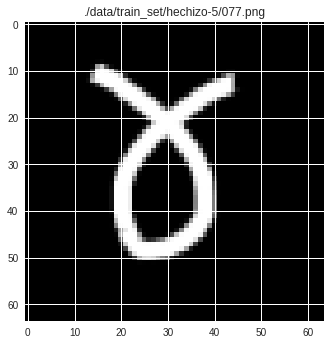

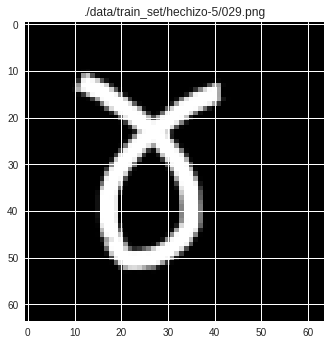

In [0]:
#### Parte 2d) Probando tu red con un modelo pre-entrenado
!git clone https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile.git  
os.chdir('./cc6204-DeepLearning-DCCUChile/2018/tareas/tarea1/recursos/varita_magica')

W1 = np.loadtxt('./modelos/ejemplo/W1.txt')
W2 = np.loadtxt('./modelos/ejemplo/W2.txt')
U = np.loadtxt('./modelos/ejemplo/U.txt')
b1 = np.loadtxt('./modelos/ejemplo/b1.txt')
b2 = np.loadtxt('./modelos/ejemplo/b2.txt')
c = np.loadtxt('./modelos/ejemplo/c.txt')

W1 = torch.from_numpy(W1)
W2 = torch.from_numpy(W2)
U = torch.from_numpy(U)
b1 = torch.from_numpy(b1)
b2 = torch.from_numpy(b2)
c = torch.from_numpy(c)
params = [[W1, W2, U], [b1, b2, c]]
nn = FFNN(4096, [15, 15], [sig, sig], 10, params=params)

input_list = []
target_list = []
images_path = []

for data in glob.glob('./data/*_set/hechizo-*/*.txt'):
  dir_path = os.path.dirname(os.path.realpath(data))
  folder = os.path.basename(dir_path)
  target = int(folder.split('-')[1])
  image_path = data.replace('.txt', '.png')
  np_data = np.reshape(np.loadtxt(data), -1);
  tensor = torch.unsqueeze(torch.from_numpy(np_data), 0)
  input_list.append(tensor)
  target_list.append(target)
  images_path.append(image_path)

target = torch.from_numpy(np.asarray(target_list))
input_data = torch.cat(input_list, 0)

if torch.cuda.is_available():
  nn.gpu()
  input_data = input_data.cuda()
  target = target.cuda()
else:
  print('PyTorch CUDA is not available.')

y_pred = nn.forward(input_data)
labels = torch.max(y_pred, 1)[1]
falses = torch.nonzero(target - labels)
acc = 1 - falses.size()[0] / target.size()[0]
print('Accuracy: ' + str(100 * acc) + ' %')

example_1_path = images_path[random.choice(falses)[0]]
example_2_path = images_path[random.choice(falses)[0]]
example_1 = misc.imread(example_1_path)
example_2 = misc.imread(example_2_path)

plt.figure()
plt.imshow(example_1[:, :, 1], cmap=plt.cm.gray)
plt.title(example_1_path)
plt.show()
plt.figure()
plt.imshow(example_2[:, :, 1], cmap=plt.cm.gray)
plt.title(example_2_path)
plt.show()

## Checkeo de gradiente

In [0]:
#### Parte 4b) Chequeo de gradiente
print('Poner aqui las 5 decimas de la entrega parcial plis, nunca cache como se hacia esto ToT')

Poner aqui las 5 decimas de la entrega parcial plis, nunca cache como se hacia esto ToT


## Descenso de gradiente, momentum, RMSProp y Adam


In [0]:
#### Parte 5a) Descenso de gradiente
#### Parte 7b) Descenso de gradiente con momentum
class SGD():
  def __init__(self, network, lr=0.001, momentum=0.9):
    self.net = network
    self.lr = lr
    self.mom = momentum
    self.V_W = [0] * len(network.W)
    self.V_b = [0] * len(network.b)
    
  def reset(self):
    self.V_W = [0] * len(self.net.W)
    self.V_b = [0] * len(self.net.b)
  
  def step(self):
    for k in range(len(self.net.W)):
      self.V_W[k] = self.mom * self.V_W[k] - self.lr * self.net.dL_dW[k]
      self.V_b[k] = self.mom * self.V_b[k] - self.lr * self.net.dL_db[k]
      self.net.W[k] += self.V_W[k]
      self.net.b[k] += self.V_b[k]

In [0]:
#### Parte 7c) RMSProp
class RMSProp():
  def __init__(self, network, lr=0.001, beta=0.9, epsilon=1e-8):
    self.net = network
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon
    self.S_W = [0] * len(network.W)
    self.S_b = [0] * len(network.b)
    
  def reset(self):
    self.S_W = [0] * len(self.net.W)
    self.S_b = [0] * len(self.net.b)
  
  def step(self):
    for k in range(len(self.net.W)):
      self.S_W[k] = self.beta * self.S_W[k] + (1 - self.beta) * self.net.dL_dW[k] * self.net.dL_dW[k]
      self.S_b[k] = self.beta * self.S_b[k] + (1 - self.beta) * self.net.dL_db[k] * self.net.dL_db[k]
      self.net.W[k] -= self.lr * self.S_W[k].sqrt().add(self.epsilon).reciprocal() * self.net.dL_dW[k]
      self.net.b[k] -= self.lr * self.S_b[k].sqrt().add(self.epsilon).reciprocal() * self.net.dL_db[k]

In [0]:
#### Parte 7d) Adam
class Adam():
  def __init__(self, network, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.net = network
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.P_W = [0] * len(network.W)
    self.P_b = [0] * len(network.b)
    self.S_W = [0] * len(network.W)
    self.S_b = [0] * len(network.b)
    self.n = 1
    
  def reset(self):
    self.P_W = [0] * len(self.net.W)
    self.P_b = [0] * len(self.net.b)
    self.S_W = [0] * len(self.net.W)
    self.S_b = [0] * len(self.net.b)
    self.n = 1
    
  def step(self):
    for k in range(len(self.net.W)):
      self.P_W[k] = self.beta1 * self.P_W[k] + (1 - self.beta1) * self.net.dL_dW[k]
      self.P_b[k] = self.beta1 * self.P_b[k] + (1 - self.beta1) * self.net.dL_db[k]
      self.S_W[k] = self.beta2 * self.S_W[k] + (1 - self.beta2) * self.net.dL_dW[k] * self.net.dL_dW[k]
      self.S_b[k] = self.beta2 * self.S_b[k] + (1 - self.beta2) * self.net.dL_db[k] * self.net.dL_db[k]
      Paux_W = self.P_W[k] / (1 - self.beta1 ** self.n)
      Paux_b = self.P_b[k] / (1 - self.beta1 ** self.n)
      Saux_W = self.S_W[k] / (1 - self.beta2 ** self.n)
      Saux_b = self.S_b[k] / (1 - self.beta2 ** self.n)
      self.net.W[k] -= self.lr * Saux_W.sqrt().add(self.epsilon).reciprocal() * Paux_W
      self.net.b[k] -= self.lr * Saux_b.sqrt().add(self.epsilon).reciprocal() * Paux_b
    self.n += 1

## Datos random para carga


In [0]:
#### Parte 5b) Datos para carga
class RandomDataset():
  def __init__(self, N, F, C):
    labels = torch.zeros(N, C)
    hot_pos = torch.rand(N, C).max(dim=1)[1]
    for i in range(len(labels)):
      labels[i][hot_pos[i]] = 1
    self.data = torch.rand(N, F)
    self.labels = labels
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, i):
    return self.data[i].view(1, len(data[i]))
  
  def batches(self, B):
    batch = []
    n_batches = int(len(self.data) / B)
    for i in range(n_batches):
      batch.append([self.data[i*B:(i + 1)*B], self.labels[i*B:(i + 1)*B]])
    return batch

## Loop de entrenamiento

In [0]:
#### Parte 5c) Entrenando la red
def accuracy(y_pred, y):
  y_pred = y_pred.max(dim=1)[1]
  y = y.max(dim=1)[1]
  tp = (y == y_pred)
  return tp.sum() / tp.size()[0]

def train_FFNN(network, dataset, optimizer, epochs, B, train_report=False):
  accuracies = []
  losses = []
  t = time.clock()
  for epoch in range(epochs):
    acc = 0
    loss = 0
    iterations = 0
    t_epoch = time.clock()
    for x, y in dataset.batches(B):
      y_pred = network.forward(x)
      network.backward(x, y, y_pred)
      optimizer.step()
      acc += accuracy(y_pred, y)
      loss += cross_ent_loss(y_pred, y)
      iterations += 1
    acc /= iterations
    loss /= iterations
    accuracies.append(acc)
    losses.append(loss)
    if train_report:
      print('Epoch: ' + str(epoch + 1) + ' | Acc: ' + str(acc) + ' | Loss: ' + str(loss) + ' | Elapsed Time: ' + str(time.clock() - t_epoch) + ' seconds')
  print('Training time: ' + str(time.clock() - t) + ' seconds')
  optimizer.reset()
  return network, accuracies, losses

## Entrenando con datos random y graficando la pérdida

Training time: 5.010078 seconds
Training time: 5.438922999999999 seconds
Training time: 5.95984 seconds


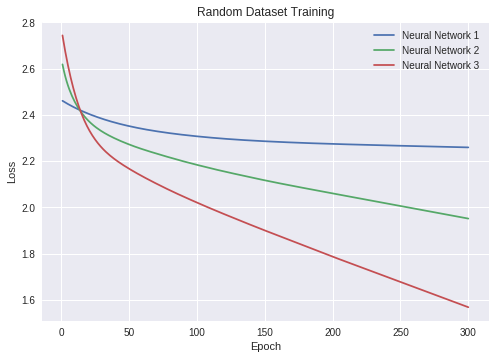

In [0]:
#### Parte 5d) Graficando la pérdida en el tiempo
F = 300; C = 10; N = 100
dataset = RandomDataset(N, F, C)

network_1 = FFNN(F, [10, 10], [relu, sig], C)
network_2 = FFNN(F, [50, 30], [relu, sig], C)
network_3 = FFNN(F, [100, 50], [relu, sig], C)

optimizer_1 = SGD(network_1, momentum=0)
optimizer_2 = SGD(network_2, momentum=0)
optimizer_3 = SGD(network_3, momentum=0)

_, accuracies_1, losses_1 = train_FFNN(network_1, dataset, optimizer_1, 300, 4)
_, accuracies_2, losses_2 = train_FFNN(network_2, dataset, optimizer_2, 300, 4)
_, accuracies_3, losses_3 = train_FFNN(network_3, dataset, optimizer_3, 300, 4)

plt.figure()
plt.plot(range(1, len(losses_1) + 1), losses_1)
plt.plot(range(1, len(losses_2) + 1), losses_2)
plt.plot(range(1, len(losses_3) + 1), losses_3)
plt.title('Random Dataset Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Neural Network 1', 'Neural Network 2', 'Neural Network 3'])
plt.show()

## Entrenando con datos de varita mágica



Training time: 35.44801499999999 seconds
Accuracy: 100.0 %


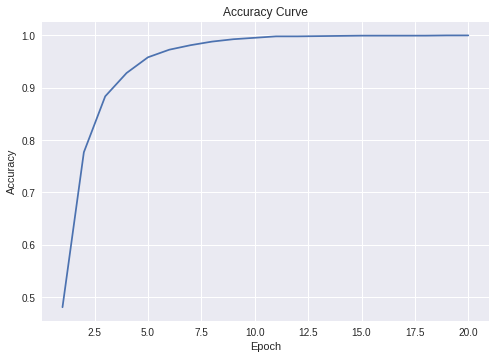

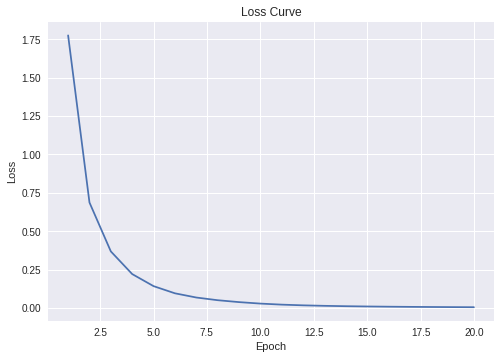

In [0]:
#### Parte 5e) Entrenando con datos no random
class Dataset():
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, i):
    return self.data[i], self.labels[i]
  
  def batches(self, B):
    batch = []
    n_batches = int(len(self.data) / B)
    for i in range(n_batches):
      batch.append([self.data[i*B:(i + 1)*B], self.labels[i*B:(i + 1)*B]])
    return batch
  
  def shuffle(self):
    perm = torch.randperm(self.__len__())
    self.data = self.data[perm]
    self.labels = self.labels[perm]

train_data = []
train_target = []

for data in glob.glob('./data/train_set/hechizo-*/*.txt'):
  dir_path = os.path.dirname(os.path.realpath(data))
  folder = os.path.basename(dir_path)
  target = int(folder.split('-')[1])
  np_data = np.reshape(np.loadtxt(data), -1);
  tensor = torch.unsqueeze(torch.from_numpy(np_data), 0);
  train_data.append(tensor)
  train_target.append(target)
  
train_targets = torch.from_numpy(np.asarray(train_target))
train_data = torch.cat(train_data, 0).type(torch.FloatTensor)
one_hot_targets = torch.zeros(len(train_targets), torch.max(train_targets) + 1)

for i in range(len(train_targets)):
  one_hot_targets[i][train_targets[i]] = 1

dataset = Dataset(train_data, one_hot_targets)
dataset.shuffle()

N = len(train_targets)
F = 4096; C = 10; B = 1;

network_1 = FFNN(F, [15, 15], [relu, relu], C)
optimizer_1 = SGD(network_1, momentum=0)
nn_1, acc_1, loss_1 = train_FFNN(network_1, dataset, optimizer_1, 20, B)

y_pred = nn_1.forward(train_data)
acc = accuracy(y_pred, one_hot_targets)
print('Accuracy: ' + str(100 * acc) + ' %')

plt.figure()
plt.plot(range(1, len(acc_1) + 1), acc_1)
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.plot(range(1, len(loss_1) + 1), loss_1)
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Cargando datos de MNIST

Cantidad de ejemplos de entrenamiento: 60000
Cantidad de ejemplos de prueba: 10000
MNIST data loaded succesfully!


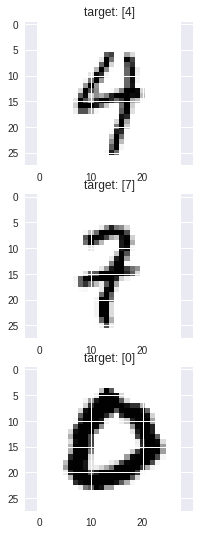

In [0]:
#### Parte 8a) Cargando y visualizando datos de MNIST

# Importamos las clases necesarias

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from matplotlib.pyplot import imshow, figure, subplots

# Descarga y almacena el conjunto de entrenamiento y prueba de MNIST
# Además aplica una transformación para convertir todas las imágenes a 
# tensores de pytroch

train_data = MNIST('mnist', train=True, download=True, transform=ToTensor())
test_data = MNIST('mnist', train=False, transform=ToTensor())

print('Cantidad de ejemplos de entrenamiento: ' + str(len(train_data)))
print('Cantidad de ejemplos de prueba: ' + str(len(test_data)))

# Muestra 3 ejemplos al azar usando un DataLoader

dataloader_train = DataLoader(train_data, shuffle=True)
dataloader_test = DataLoader(test_data)
n_ejemplos = 3

fig, axs = subplots(nrows=n_ejemplos, sharey=True, figsize=(3,n_ejemplos*3))

for i, batch in enumerate(dataloader_train):
  if i == n_ejemplos:
    break
    
  img, d = batch
  axs[i].set_title("target: " + str(d.numpy()))
  axs[i].imshow(img.view(28,28).numpy())
  
# Data loading
MNIST_train_data = []
MNIST_train_targets = []
MNIST_test_data = []
MNIST_test_targets = []

for i_batch, sample_batched in enumerate(dataloader_train):
  data, target = sample_batched
  data = data.view(1, int(np.prod(list(data.size()))))
  one_hot_target = torch.zeros(1, 10)
  one_hot_target[0][target[0]] = 1
  MNIST_train_data.append(data)
  MNIST_train_targets.append(one_hot_target)

for i_batch, sample_batched in enumerate(dataloader_test):
  data, target = sample_batched
  data = data.view(1, int(np.prod(list(data.size()))))
  one_hot_target = torch.zeros(1, 10)
  one_hot_target[0][target[0]] = 1
  MNIST_test_data.append(data)
  MNIST_test_targets.append(one_hot_target)

MNIST_train_data = torch.cat(MNIST_train_data, 0)
MNIST_train_targets = torch.cat(MNIST_train_targets, 0)
MNIST_test_data = torch.cat(MNIST_test_data, 0)
MNIST_test_targets = torch.cat(MNIST_test_targets, 0)

if torch.cuda.is_available():
  MNIST_train_data = MNIST_train_data.cuda()
  MNIST_train_targets = MNIST_train_targets.cuda()
  MNIST_test_data = MNIST_test_data.cuda()
  MNIST_test_targets = MNIST_test_targets.cuda()

MNIST_train_dataset = Dataset(MNIST_train_data, MNIST_train_targets)
MNIST_test_dataset = Dataset(MNIST_test_data, MNIST_test_targets)
print('MNIST data loaded succesfully!')

## Red neuronal para MNIST

Training time: 1483.1750789999999 seconds


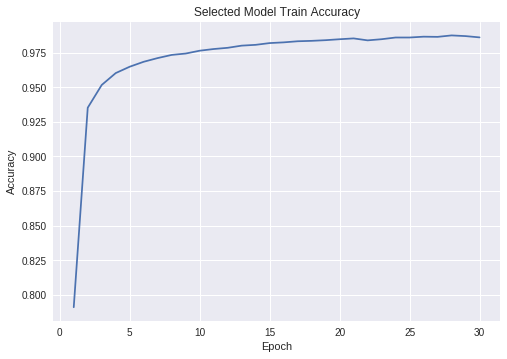

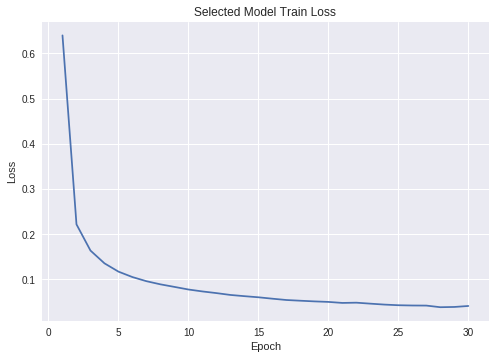

Test accuracy: 96.11 %


In [0]:
#### Parte 8b) Red neuronal para MNIST
N = len(MNIST_train_data)
F = 784; C = 10; B = int(N/N);

net_mnist = FFNN(F, [30, 15], [relu, relu], C, init='xavier')
optimizer_mnist = SGD(net_mnist, momentum=0.6)
net_mnist, acc_mnist, loss_mnist = train_FFNN(net_mnist, MNIST_train_dataset, optimizer_mnist, 30, B)

plt.figure()
plt.plot(range(1, len(acc_mnist) + 1), acc_mnist)
plt.title('Selected Model Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.plot(range(1, len(loss_mnist) + 1), loss_mnist)
plt.title('Selected Model Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

y_pred = net_mnist.forward(MNIST_test_data)
acc_test_1 = accuracy(y_pred, MNIST_test_targets)
print('Test accuracy: ' + str(100 * acc_test_1) + ' %')

El proceso de selección de hiperparámetros del modelo escogido se detalla a continuación:

*   Número de capas y neuronas: Se probaron distintas configuraciones, donde se escogieron 2 capas ocultas de 30 y 15 neuronas respectivamente, ya que la tarea de clasificaicón no se consideró compleja en función de la cantidad de parámetros de entrada, por lo cual, dicha selección otorga un buen rendimiento en pocas épocas de entrenamiento.

*   Número de épocas: Como el modelo escogido no presentaba tantos parámetros, se escogieron 30 épocas, en las cuales se observó que le entrenamiento lograba convergencia.

*   Tasa de aprendizaje: Se escogió la tasa de aprendizaje por defecto 0.001, ya que esta permitia un paso de actulizacion adecuado de los parámetros del modelo, logrando aproximarse en gran medida al óptimo global.

*   Funciones de activación: Se escogieron 2 funciones de activación Relu ya que estas presentaban los mejores resultados en comparacion con las demás.

*   Inicialización: Se inicializaron los parámetros de acuerdo a la inicizalización de xavier, ya que esta incialización considera podnerar los parametros de las capas de acuerdo a la cantidad de neuronas y pondera de manera distinta a las capas con funcion de activación Relu, las cuales fueron utilizadas en la arquitectura propuesta.

*   Batch: Se escogió un batch unitario para maximmizar los ajustes de parámetros mediante el backpropagation.

*   Optimizador: Se escogíó el optimizador SGD con momentum, ya que este presentó los mejors resultados de entrenamiento (Ver sección siguiente).

*   Momentum: Se escogió un factor de momentum de 0.6 ya qye este presentó los mejores resultados de entrenamiento (Ver sección siguiente).

*   Regularización: No se utilizó ningún método de regularización (Dropout, Norma L2) ya que el modelo no alcanzaba a sobreajustarse a los datos de entrenamiento, por lo cual, no se consideró necesario.

El modelo propuesto obtuvo un 96.11 % de accuracy sobre el conjunto de prueba.






Training time: 1142.7019599999999 seconds
Training time: 1180.5394589999999 seconds
Training time: 1294.2045309999999 seconds
Training time: 1249.8738999999996 seconds


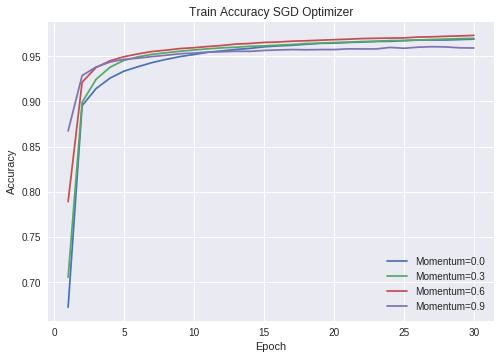

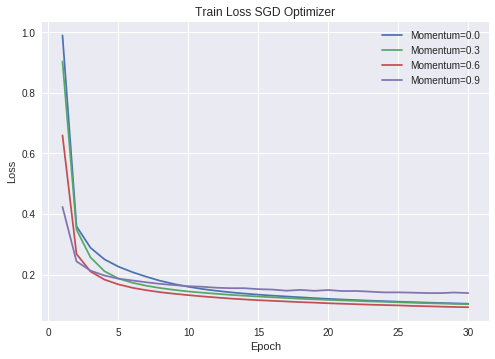

In [0]:
#### Parte 8c) Visualización de entrenamiento y convergencia

# Precision y pérdida por época para distintos parámetros de momentum dado que dejamos fijo a SGD
N = len(MNIST_train_data)
F = 784; C = 10; B = int(N/N)

net_sgd_1 = FFNN(F, [15, 15], [relu, relu], C, init='xavier')
net_sgd_2 = FFNN(F, [15, 15], [relu, relu], C, init='xavier')
net_sgd_3 = FFNN(F, [15, 15], [relu, relu], C, init='xavier')
net_sgd_4 = FFNN(F, [15, 15], [relu, relu], C, init='xavier')

optimizer_sgd_1 = SGD(net_sgd_1, momentum=0.0)
optimizer_sgd_2 = SGD(net_sgd_2, momentum=0.3)
optimizer_sgd_3 = SGD(net_sgd_3, momentum=0.6)
optimizer_sgd_4 = SGD(net_sgd_4, momentum=0.9)

net_sgd_1, acc_sgd_1, loss_sgd_1 = train_FFNN(net_sgd_1, MNIST_train_dataset, optimizer_sgd_1, 30, B)
net_sgd_2, acc_sgd_2, loss_sgd_2 = train_FFNN(net_sgd_2, MNIST_train_dataset, optimizer_sgd_2, 30, B)
net_sgd_3, acc_sgd_3, loss_sgd_3 = train_FFNN(net_sgd_3, MNIST_train_dataset, optimizer_sgd_3, 30, B)
net_sgd_4, acc_sgd_4, loss_sgd_4 = train_FFNN(net_sgd_4, MNIST_train_dataset, optimizer_sgd_4, 30, B)

plt.figure()
plt.plot(range(1, len(acc_sgd_1) + 1), acc_sgd_1)
plt.plot(range(1, len(acc_sgd_2) + 1), acc_sgd_2)
plt.plot(range(1, len(acc_sgd_3) + 1), acc_sgd_3)
plt.plot(range(1, len(acc_sgd_4) + 1), acc_sgd_4)
plt.title('Train Accuracy SGD Optimizer')
plt.legend(['Momentum=0.0', 'Momentum=0.3', 'Momentum=0.6', 'Momentum=0.9'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.plot(range(1, len(loss_sgd_1) + 1), loss_sgd_1)
plt.plot(range(1, len(loss_sgd_2) + 1), loss_sgd_2)
plt.plot(range(1, len(loss_sgd_3) + 1), loss_sgd_3)
plt.plot(range(1, len(loss_sgd_4) + 1), loss_sgd_4)
plt.title('Train Loss SGD Optimizer')
plt.legend(['Momentum=0.0', 'Momentum=0.3', 'Momentum=0.6', 'Momentum=0.9'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Se aprecia que el modelo que presenta menor overfitting resulta el de momentum igual a 0.9, por lo que se asume que la ponderación de la velocidad asociada a la actualización de los gradientes de los parámetros es muy alta, dando pasos de actualización muy gradnes, impidiendo que se alcanze el óptimo global. Al no añadir un factor ponderador a la velocidad de los gradientes (momentum 0), se aprecia que el modelo demora más en converger, concordando con lo esperado. Finalmente se observa que la tasa de momentum óptima para alcanzar un mayor accuracy de entrenamiento resultó ser el momentum 0.6, siendo un punto medio entre los ya mencionados.

Training time: 1140.1516110000002 seconds
Training time: 1340.4231179999997 seconds
Training time: 2200.4656129999994 seconds
Training time: 2823.853185 seconds


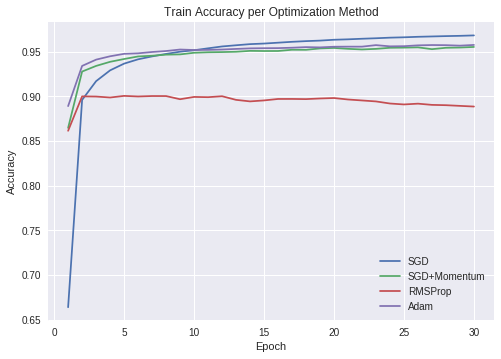

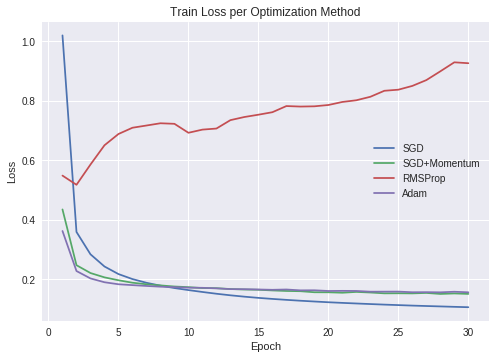

In [0]:
# Precision y pérdida por época para distintos métodos de optimización (SGD, SGD+momentum, RMSProp, Adam)
N = len(MNIST_train_data)
F = 784; C = 10; B = int(N/N)

net_sgd = FFNN(F, [15, 15], [relu, relu], C, init='xavier')
net_sgd_mom = FFNN(F, [15, 15], [relu, relu], C, init='xavier')
net_rmsprop = FFNN(F, [15, 15], [relu, relu], C, init='xavier')
net_adam = FFNN(F, [15, 15], [relu, relu], C, init='xavier')

optimizer_sgd = SGD(net_sgd, momentum=0)
optimizer_sgd_mom = SGD(net_sgd_mom)
optimizer_rmsprop = RMSProp(net_rmsprop)
optimizer_adam = Adam(net_adam)

net_sgd, acc_sgd, loss_sgd = train_FFNN(net_sgd, MNIST_train_dataset, optimizer_sgd, 30, B)
net_sgd_mom, acc_sgd_mom, loss_sgd_mom = train_FFNN(net_sgd_mom, MNIST_train_dataset, optimizer_sgd_mom, 30, B)
net_rmsprop, acc_rmsprop, loss_rmsprop = train_FFNN(net_rmsprop, MNIST_train_dataset, optimizer_rmsprop, 30, B)
net_adam, acc_adam, loss_adam = train_FFNN(net_adam, MNIST_train_dataset, optimizer_adam, 30, B)

plt.figure()
plt.plot(range(1, len(acc_sgd) + 1), acc_sgd)
plt.plot(range(1, len(acc_sgd_mom) + 1), acc_sgd_mom)
plt.plot(range(1, len(acc_rmsprop) + 1), acc_rmsprop)
plt.plot(range(1, len(acc_adam) + 1), acc_adam)
plt.title('Train Accuracy per Optimization Method')
plt.legend(['SGD', 'SGD+Momentum', 'RMSProp', 'Adam'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.plot(range(1, len(loss_sgd) + 1), loss_sgd)
plt.plot(range(1, len(loss_sgd_mom) + 1), loss_sgd_mom)
plt.plot(range(1, len(loss_rmsprop) + 1), loss_rmsprop)
plt.plot(range(1, len(loss_adam) + 1), loss_adam)
plt.title('Train Loss per Optimization Method')
plt.legend(['SGD', 'SGD+Momentum', 'RMSProp', 'Adam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<body style=”text-align: justify;”>
Se observa que el optimizador que presenta mayor overfitting es el SGD sin momentum, debido a que el proceso de actualización no se ve acelerado por ningún factor, a diferencia de los demás métodos de optimización, convergiendo de manera más precisa al mínimo global. Este resultado pudo haber diferido si es que el modelo hubiera presentado mayor complejidad, donde la probabilidad de estancar la optimización en un mínimo local es más alta, pudiendo presentar mejor resultado cualquiera de los otros métodos que ponderan la actualización de parámetros por algún factor.
Se aprecia también que el optimizador de peor resultado es RMSProp, aumentando su pérdida al aumentar las épocas de entrenamiento, por lo que se concluye que el promedio móvil exponencial de los cuadrados de los gradientes computados impacta en gran medida la evolución de este, alejando el mismo del mínimo global en cada época ya que se estarán considerando gradientes pasados en dirección errónea.
</body>

---

## Apéndice: partes a mano

### Parte 1b) Derivando las funciones de activación

\begin{equation}
\begin{split}
\frac{\partial\ \text{relu}(x)}{\partial x} & = \left\{ \begin{array}{c} 1 & , & x > 0 \\ 0 & , & x < 0 \end{array}\right. \\
\end{split}
\end{equation}
<br><br>

\begin{equation}
\begin{split}
\text{sigmoid}(x) & = \frac{1}{1+\exp(-x)} \\
\\
\frac{\partial\ \text{sigmoid}(x)}{\partial x} & = \frac{\exp(-x)}{\big(1+\exp(-x)\big)^2} \\
& = \frac{1-1+\exp(-x)}{\big(1+\exp(-x)\big)^2} \\ 
& = \frac{1+\exp(-x)}{\big(1+\exp(-x)\big)^2} - \frac{1}{\big(1+\exp(-x)\big)^2} \\
& = \frac{1}{1+\exp(-x)} - \frac{1}{\big(1+\exp(-x)\big)^2} \\ 
& = \text{sigmoid}(x) - \text{sigmoid}(x)^2 \\
& = \text{sigmoid}(x)\big(1-\text{sigmoid}(x)\big)\\ 
\end{split}
\end{equation}
<br><br>

\begin{equation}
\begin{split}
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} & = \text{sigmoid}(\beta x)+\beta x\cdot\text{sigmoid}(\beta x)\big(1-\text{sigmoid}(\beta x)\big) \\
& = \text{sigmoid}(\beta x)+\beta x\cdot\text{sigmoid}(\beta x)-\beta x\cdot\text{sigmoid}(\beta x)^2 \\
& = \beta x\cdot\text{sigmoid}(\beta x)+\text{sigmoid}(\beta x)\big(1-\beta x\cdot\text{sigmoid}(\beta x)\big) \\
& = \beta\cdot\text{swish}(x,\beta)+\text{sigmoid}(\beta x)\big(1-\beta\cdot\text{swish}(x, \beta)\big) \\
\\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & = x^2\cdot\text{sigmoid}(\beta x)\big(1-\text{sigmoid}(\beta x)\big) \\
& = x^2\cdot\text{sigmoid}(\beta x)-x^2\cdot\text{sigmoid}(\beta x)^2 \\
& = x\cdot\text{swish}(x, \beta)-\text{swish}(x, \beta)^2 \\
\end{split}
\end{equation}
<br><br>

\begin{equation}
\begin{split}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & = \left\{ \begin{array}{c} 1 & , & x \geq 0 \\ \alpha \frac{1}{\alpha}\big( \exp\big(\frac{x}{\alpha}\big)-0\big) & , & x < 0 \end{array}\right. \\
& = \left\{ \begin{array}{c} 1 & , & x \geq 0 \\ \exp\big(\frac{x}{\alpha}\big) & , & x < 0 \end{array}\right. \\
\\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = \left\{ \begin{array}{c} 0 & , & x \geq 0 \\ \exp\big(\frac{x}{\alpha}\big)-1+\alpha\exp\big(\frac{x}{\alpha}\big)\frac{-x}{\alpha^2} & , & x < 0 \end{array}\right. \\
& = \left\{ \begin{array}{c} 0 & , & x \geq 0 \\ \exp\big(\frac{x}{\alpha}\big)-\frac{x}{\alpha}\exp\big(\frac{x}{\alpha}\big)-1 & , & x < 0 \end{array}\right. \\
& = \left\{ \begin{array}{c} 0 & , & x \geq 0 \\ \exp\big(\frac{x}{\alpha}\big)\big(1-\frac{x}{\alpha}\big)-1 & , & x < 0 \end{array}\right. \\
\end{split}
\end{equation}

### Parte 3b) Derviando la última capa

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L)}} = \frac{1}{N}(\hat{y}-y)
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial U} = \frac{\partial \cal L}{\partial u^{(L)}}h^{(L-1)} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial c} = Sum\Bigg(\frac{\partial \cal L}{\partial u^{(L)}}\Bigg) \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L-1)}} = \frac{\partial \cal L}{\partial u^{(L)}} * U \\
\end{equation}

### Parte 3c) Derivando desde las capas escondidas

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}}\frac{\partial\cal f\big(u^{(k)}\big)}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = \big(h^{(k-1)}\big)^{T}\frac{\partial\cal L}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = Sum_1\Bigg(\frac{\partial\cal L}{\partial u^{(k)}}\Bigg) \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} \big(W^{(k)}\big)^{T} \\
\end{equation}
<br><br>

### Otras derivadas (derivadas opcionales de celu y swish, de batch normalization, etc.)